# CSII 2024 Exercise 11: Nonlinear Control Part 1
&copy; 2024 ETH Zurich, Felix Schnitzler, Jungcheng Fu, Dejan Milojevic, Paolo Petri, Joël Gmür; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

## Description
This week's Jupyter notebook will cover feedback linearization and differential flatness.


As usual, we start by installing the `control` module and import the required libraries.

In [ ]:
# Install the required python library with pip 
%pip install control

In [ ]:
import numpy as np
import control as ct
import control.flatsys as fs
import matplotlib.pyplot as plt

## Problem 1
You are an engineer on a racing team for Formula 1 and you are currently working on optimizing the drag force on your teams racecar. To model the vehicles behaviour you need to recall the equation for Drag force that you first learned about at ETH.
$$ F_{d} = \frac{1}{2}\rho c_d A\dot{x}(t)^2 , $$ 
where $\rho$ is the density of air, $c_d$ is the drag coefficient and $A$ is the affected reference area.
We model the total force $F_{tot}$ on the vehicle as the combination of the input acceleration $a_{m}$ and the drag force $F_d$:
$$ F_{tot} = m a_m - F_d$$
Writing this in familiar notation we get:
$$ m\ddot{x}(t) = -\frac{1}{2}\rho c_d A\dot{x}(t)^2 + mu(t)$$
Since we are interested in the velocity of the system, we can transform this into a first order differential equation by setting $v(t) = \dot{x}(t)$. The total system now reads:
\begin{align*}
\dot{v}(t) &= -\gamma v(t)^2 + u(t)\\
y(t) &= v(t)
\end{align*}
where $\gamma = \frac{1}{2m}\rho c_d A$ and $y(t)$ is the output of the system.


### Exercise 1.1

Define the nonlinear system in the function 'nonlinear_system' below. The function should take the state $x$, the input $u$ and the parameters $\gamma$ as arguments and return the derivative of the state $vdot$ as well as the output $y$.

In [ ]:
gamma = 0.5*1.225*0.8*2.0/800

# Source Gemini AI
# Fd = 0.5 * 1.225 kg/m³ * (83.3 m/s)² * 0.8 * 2.0 m²
# Fd = 88,200 N
# A Formula 1 car weighs a minimum of 798 kilograms (which is about 1,759 pounds). 

print(gamma)

def nonlinear_sys(t, v, u, params=(gamma)):
  vdot = -gamma*v**2 + u
  return vdot

def nonlinear_sys_out(t, v, u, params=(None)):
  y = v
  return y

### Exercise 1.2

Using the control library, define the input-output system 'sys' and simulate the response of the system.
Hint: You can use the function ct.NonlinearIOSystem() to define 'sys'.

In [ ]:
sys = ct.NonlinearIOSystem(nonlinear_sys, nonlinear_sys_out)

w = np.pi*2

t = np.linspace(0, 30, 1000)
u = np.sin(w * t) * 0 + 20

# Gemini AI

'''
 The initial g force for acceleration of a Formula 1 car 
 typically falls in the range of 1.45 g to 2.0 g. 
 This translates to an acceleration of 14.2 m/s² to 19.6 m/s², 
 which is a very impressive push back into the driver's seat.
 
 Sure, here are the maximum speeds of Formula 1 car in m/s:
 Race	103.47
 Theoretical	138.33
 
 magnitude matched with the codes now
'''

t_out, y_out = ct.input_output_response(sys, T=t, U=u, X0=[0])

print('t=',t_out[999],'speed=',y_out[0,999])




Now we plot the data to see how the system behaves.

In [ ]:
# Plot the response
plt.plot(t_out, y_out[0], label='y=v')  # theta output
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Velocity of nonlinear system')
plt.legend()
plt.grid(True)
plt.show()


### Exercise 1.3

Now we accelerate the car from $v_0 = 0 m/s$ with input acceleration of roughly $2G$
$$v_0 = 0$$
$$u = 20$$
Find the equilibrium point of the system, corresponding to the stagnation speed of this engine power input.

_Hint: The system function is symmetrical, thus, when the initial state $ x_0 = 0$, it may take the negative solution. Set a slight positive number to get a positive solution_


In [ ]:
# TODO:

v_eq,u_eq,y_eq = ct.find_eqpt(sys, [1], [20], return_y=True)
print("Equilibrium speed:", v_eq,"m/s")
print(u_eq)
print(y_eq)

### Exercise 1.4

Now we want to control the car acceleration at around the stagnation speed in windy weather (wind speed fluctuates a bit) using LTI control theory. Linearize the system around this point. Speed xxx, input xxx.

In [194]:
# TODO:

# 
print("Stagnation Speed = ", v_eq[0] ,"m/s")
print("Initial acceleration input = ", u_eq[0], "m/s²")

linearized_sys = ct.linearize(sys,[v_eq],[u_eq])

A_matrix = linearized_sys.A


Stagnation Speed =  127.77531299998796 m/s
Initial acceleration input =  20 m/s²


### Exercise 1.5

Now we have our linearized system, we want to use this system model to calculate the compensation acceleration of a sudden increase in wind speed.

The linearized system simply takes the slope of the nonlinear function at that given speed point and doesn't have an offset. So the calculation with the linearized system must add an offset to it, hence we must subtract the equilibrium point.

In [197]:
# Wind speed increases to 128 m/s
v_current = 128 
u_current = 21

# Prepare for linearized system calculation
delta_v = v_current - v_eq
delta_u = 0

# Solve the equation for the compensation 
# acceleration to maintain the same ground speed
delta_u = -A_matrix*delta_v

print("Linear model based wind speed = ", v_eq[0], "m/s")
print("Current wind speed = ", v_current, "m/s")
print("(Speed difference) = ", delta_v[0], "m/s")
print("Compensation Acc. = ", delta_u[0,0], "m/s²")

Linear model based wind speed =  127.77531299998796 m/s
Current wind speed =  128 m/s
(Speed difference) =  0.22468700001203956 m/s
Compensation Acc. =  0.07033815642535002 m/s²


Now we simulate the system to validate if the calculation is correct.

Hint, pay attention to the unit or magnitude of the plot!

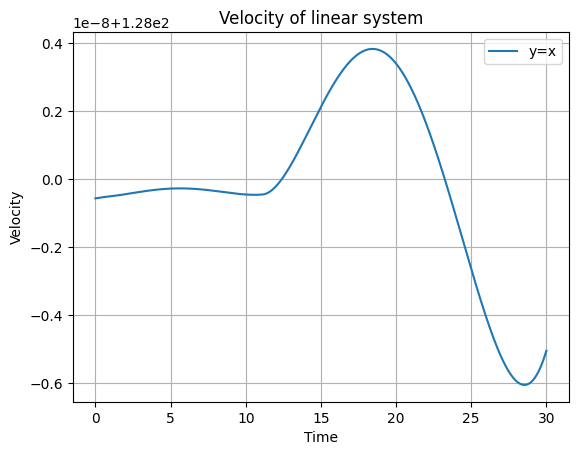

t= 30.0 s speed= 127.99999999495157 m/s


In [198]:
# Simulate the system to validate if the calculation is correct.
t = np.linspace(0, 30, 1000)
delta_u = np.ones_like(t) * delta_u
t_out, delta_y_out = ct.input_output_response(linearized_sys, T=t, U=delta_u, X0=[delta_v])

y_out = y_eq + delta_y_out

# Plot the response
plt.plot(t_out, y_out, label='y=x') 
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Velocity of linear system')
plt.legend()
plt.grid(True)
plt.show()

print('t=',t_out[999],"s",'speed=',y_out[999],"m/s")

We observed the linearized system response with the compensation acceleration to the current wind gust can very well maintain the car at a constant ground speed.

Now we validate this through plugging in the same data into the nonlinear system.

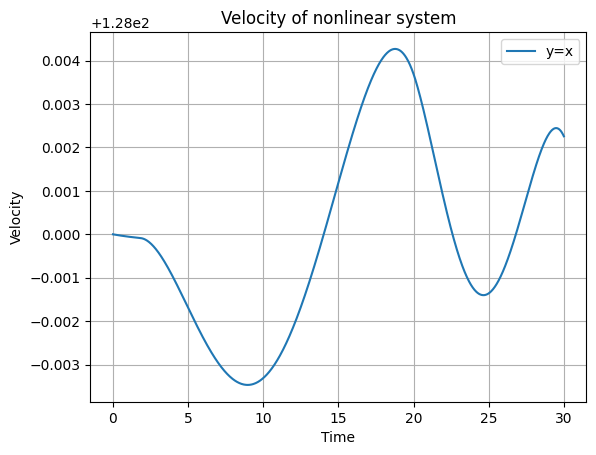

t= 30.0 s speed= 128.00225793286364 m/s


In [199]:



# Validation using the original system

t_out, y_out = ct.input_output_response(sys, T=t, U=(u+delta_u), X0=[v_current])

# Plot the response
plt.plot(t_out, y_out[0], label='y=x') 
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Velocity of nonlinear system')
plt.legend()
plt.grid(True)
plt.show()

print('t=',t_out[999],"s",'speed=',y_out[0,999],"m/s")

we noticed that the linearized system gives a very similar response compared with the nonlinear one.
Conclusion:
Using this, we can linearize a nonlinear function around any point and make a LTI system with matrixes A,B,C,D to apply our familiar control theories.